In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hms-harmful-brain-activity-classification/sample_submission.csv
/kaggle/input/hms-harmful-brain-activity-classification/train.csv
/kaggle/input/hms-harmful-brain-activity-classification/test.csv
/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/2208063991.parquet
/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/1712674008.parquet
/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/3959808174.parquet
/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/2958965493.parquet
/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/3973731145.parquet
/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/3725914929.parquet
/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/2917825580.parquet
/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/3497339021.parquet
/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/1378333210.parquet
/kaggle/input/hms

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

In [3]:
BASE_PATH = "/kaggle/input/hms-harmful-brain-activity-classification"
class_names = ['Seizure', 'LPD', 'GPD', 'LRDA','GRDA', 'Other']
label2name = dict(enumerate(class_names))
name2label = {v:k for k, v in label2name.items()}

In [4]:
df = pd.read_csv(f'{BASE_PATH}/train.csv')
df['eeg_path'] = f'{BASE_PATH}/train_eegs/'+df['eeg_id'].astype(str)+'.parquet'
df['spec_path'] = f'{BASE_PATH}/train_spectrograms/'+df['spectrogram_id'].astype(str)+'.parquet'
df['class_name'] = df.expert_consensus.copy()
df['class_label'] = df.expert_consensus.map(name2label)
display(df.head())

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,eeg_path,spec_path,class_name,class_label
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,Seizure,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,Seizure,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,Seizure,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,Seizure,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,Seizure,0


In [5]:
df.shape

(106800, 19)

In [6]:
df_1 = pd.read_parquet(df['eeg_path'][0])
df_1.head()

,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-80.519997,-70.540001,-80.110001,-108.750000,-120.330002,-88.620003,-101.750000,-104.489998,-99.129997,-90.389999,-97.040001,-77.989998,-88.830002,-112.120003,-108.110001,-95.949997,-98.360001,-121.730003,-106.449997,7.920000
1,-80.449997,-70.330002,-81.760002,-107.669998,-120.769997,-90.820000,-104.260002,-99.730003,-99.070000,-92.290001,-96.019997,-84.500000,-84.989998,-115.610001,-103.860001,-97.470001,-89.290001,-115.500000,-102.059998,29.219999
2,-80.209999,-75.870003,-82.050003,-106.010002,-117.500000,-87.489998,-99.589996,-96.820000,-119.680000,-99.360001,-91.110001,-99.440002,-104.589996,-127.529999,-113.349998,-95.870003,-96.019997,-123.879997,-105.790001,45.740002
3,-84.709999,-75.339996,-87.480003,-108.970001,-121.410004,-94.750000,-105.370003,-100.279999,-113.839996,-102.059998,-95.040001,-99.230003,-101.220001,-125.769997,-111.889999,-97.459999,-97.180000,-128.940002,-109.889999,83.870003
4,-90.570000,-80.790001,-93.000000,-113.870003,-129.960007,-102.860001,-118.599998,-101.099998,-107.660004,-102.339996,-98.510002,-95.300003,-88.930000,-115.639999,-99.800003,-97.500000,-88.730003,-114.849998,-100.250000,97.769997


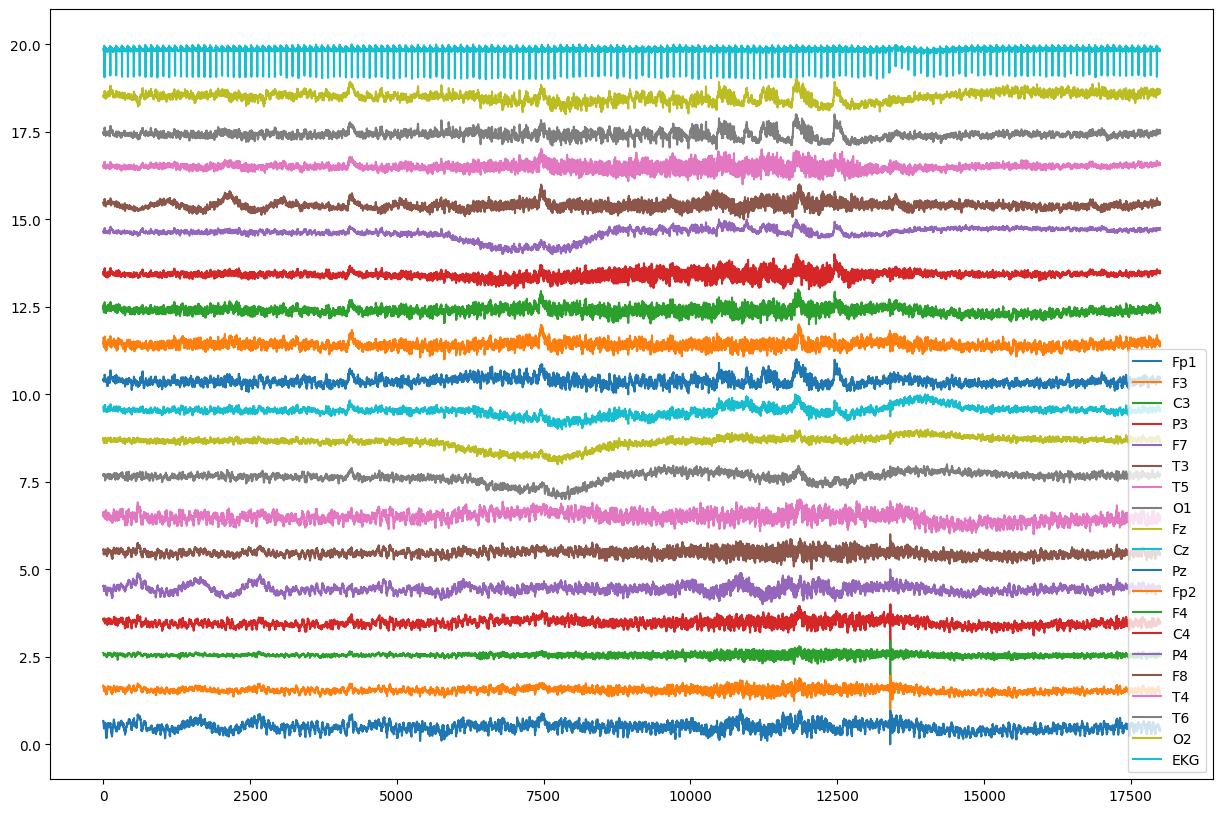

In [7]:
normalized_df_1 = (df_1-df_1.min())/(df_1.max()-df_1.min())
plt.figure(figsize=(15,10))
count=0
for col in df_1.columns:
    plt.plot(normalized_df_1[col] + count, label = col)
    count+=1

plt.legend()
plt.show()